# Исследование базы данных с заказами пользователей доставки продуктов на дом.

<h2> Инсайты: </h2> <br>
1) 92% выручки за период c 2018-01-05 по 2019-08-04 принес город 1 <br>

2) 46% выручки в период c 2018-01-05 по 2019-08-04 принесли магазины 12, 21, 2, 14 <br>

3) 97% выручки за исследуемый период принес рейтейлер 1 <br>

4) С марта 2019 года начлася ежемесячный рост количества заказов, пользователей, выручки и позиций в каждом чеке. <br>

5) 18, 112 и 120 магазины практически никак не влияли на выручку: мало заказов. Рост с февраля 2019 скорее всего связан как с увеличением выручки у "старых" популярных магазинов (например, 2, 12, 14, 21), так и с появлением 105 и 108 магазина, которые достаточно быстро завоевали популярность у юзеров <br>

6) "Постоянные юзеры" составляют 1,5% от общего числа юзеров, они принесли 33% выручки. Медианное значение для частоты заказов – 1 раз в 8 дней, медианное значение для количекства заказов – 31.
"Непостоянные юзеры" составляют 98,5% от общего числа юзеров, они принесли 67% выручки. Медианное значение для количества их заказов – 1.


In [1]:
import psycopg2 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing

%matplotlib inline

sns.set(style="whitegrid")

In [2]:
# подключаемся к бд

con = psycopg2.connect(
    host='_',
    port=_,
    dbname='_',
    sslmode='_',
    user='_',
    password='_'
)

In [3]:
cur = con.cursor()

In [4]:
cur.execute('select id, created_at from orders')

In [5]:
rows = cur.fetchall()

In [6]:
# подгружаем таблицы orders и stores, делаем join по id магазина
orders = pd.read_sql(
    'select o.id, o.user_id, o.total_cost, o.item_total, o.promo_total, o.total_quantity, o.created_at, o.store_id , s.city, s.retailer_id from orders o left join stores s on o.store_id = s.id', 
    con
    )

In [7]:
orders.head()

,id,user_id,total_cost,item_total,promo_total,total_quantity,created_at,store_id,city,retailer_id
0,3158715,61138,290.0,2543,0.0,35,2018-01-05 00:07:04,2,1.0,1.0
1,3182881,73307,190.0,6076,0.0,52,2018-01-05 02:04:42,10,1.0,1.0
2,3146329,75386,290.0,2617,0.0,24,2018-01-05 02:07:35,14,1.0,1.0
3,3150465,45970,290.0,3422,0.0,23,2018-01-05 02:15:15,21,1.0,1.0
4,3169087,49089,90.0,3666,0.0,31,2018-01-05 02:48:52,3,1.0,1.0


In [8]:
# заменим nan в city на ноль
orders.city = orders.city.fillna(0).map(int)

# заменим nan в retailer_id на 0
orders.retailer_id = orders.retailer_id.fillna(0).map(int)


## Инсайт 1
92% выручки за период c 2018-01-05 по 2019-08-04 принес город 1

In [9]:
# тоталы по городам

city_info = orders.groupby(['city']).agg({'user_id': 'nunique',
                              'total_cost': 'sum',
                              'store_id': 'nunique',
                              'retailer_id': 'nunique'}) \
                        .rename(columns={'user_id': 'users',
                                         'total_cost': 'total_spent',
                                         'store_id': 'stores',
                                         'retailer_id': 'retailers'}) \
                        .reset_index()

In [10]:
# доля выручки в каждом городе от общей выручки

spent_ratio_city = pd.DataFrame()

for amount in city_info.total_spent:
    ratio = amount/city_info.total_spent.sum()
    city = city_info.city[city_info.total_spent == amount]
    temp_spent_ratio = pd.DataFrame({
        'city': city,
        'spent_ratio': [ratio]
    })
    
    spent_ratio_city = spent_ratio_city.append(temp_spent_ratio.round(2), ignore_index=True)

city_info = city_info.merge(spent_ratio_city[['city', 'spent_ratio']])

city_info

,city,users,total_spent,stores,retailers,spent_ratio
0,0,1196,268862.00,3,1,0.00
1,1,99885,57878487.42,17,4,0.92
2,2,5539,2143379.00,5,3,0.03
3,5,3163,650356.00,2,1,0.01
4,8,2461,430433.00,1,1,0.01
5,10,3748,858890.00,2,1,0.01
6,13,1688,338410.80,1,1,0.01
7,20,1050,354778.00,1,1,0.01
8,23,1092,271848.00,1,1,0.00


## Инсайт 2
46% выручки в период c 2018-01-05 по 2019-08-04 принесли магазины 12, 21, 2, 14

In [11]:
# тоталы по магазинам

stores_info = orders.groupby(['store_id']).agg({
                              'user_id': 'nunique',
                              'total_cost': 'sum'}) \
                        .rename(columns={'user_id': 'users',
                                         'total_cost': 'total_spent'}) \
                        .reset_index()

In [12]:
stores_info.head()

,store_id,users,total_spent
0,1,9869,5393335.09
1,2,12480,7146505.04
2,3,8416,3526865.20
3,6,358,96682.00
4,8,10777,5556032.50


In [13]:
# доля выручки от каждого магазина от общей выручки

spent_ratio_store = pd.DataFrame()

for amount in stores_info.total_spent:
    ratio = amount/stores_info.total_spent.sum()
    store = stores_info.store_id[stores_info.total_spent == amount]
    temp_spent_ratio = pd.DataFrame({
        'store_id': store,
        'spent_ratio': [ratio]
    })
    
    spent_ratio_store = spent_ratio_store.append(temp_spent_ratio.round(2), ignore_index=True)

stores_info = stores_info.merge(spent_ratio_store[['store_id', 'spent_ratio']])

In [14]:
stores_info.head()

,store_id,users,total_spent,spent_ratio
0,1,9869,5393335.09,0.09
1,2,12480,7146505.04,0.11
2,3,8416,3526865.20,0.06
3,6,358,96682.00,0.00
4,8,10777,5556032.50,0.09


## Инсайт 3
97% выручки за исследуемый период принес рейтейлер 1

In [15]:
orders.head()

,id,user_id,total_cost,item_total,promo_total,total_quantity,created_at,store_id,city,retailer_id
0,3158715,61138,290.0,2543,0.0,35,2018-01-05 00:07:04,2,1,1
1,3182881,73307,190.0,6076,0.0,52,2018-01-05 02:04:42,10,1,1
2,3146329,75386,290.0,2617,0.0,24,2018-01-05 02:07:35,14,1,1
3,3150465,45970,290.0,3422,0.0,23,2018-01-05 02:15:15,21,1,1
4,3169087,49089,90.0,3666,0.0,31,2018-01-05 02:48:52,3,1,1


In [16]:
# соберем информацию по ретейлерам

retailers_info = orders.groupby('retailer_id').agg({
    'user_id': 'nunique',
    'id': 'count',
    'total_cost': 'sum',
    'store_id': 'nunique'
    }).rename(columns={
    'user_id': 'unique_customers',
    'id': 'total_orders',
    'total_cost': 'earned',
    'store_id': 'stores'
}).reset_index()

In [17]:
# доля выручки от каждого ретейлера от общей выручки

earned_ratio_retailer = pd.DataFrame()

for amount in retailers_info.earned:
    ratio = amount/retailers_info.earned.sum()
    retailer = retailers_info.retailer_id[retailers_info.earned == amount]
    temp_earned_ratio = pd.DataFrame({
        'retailer_id': retailer,
        'earned_ratio': [ratio]
    })
    
    earned_ratio_retailer = earned_ratio_retailer.append(temp_earned_ratio.round(2), ignore_index=True)

retailers_info = retailers_info.merge(earned_ratio_retailer[['retailer_id', 'earned_ratio']])

In [18]:
retailers_info

,retailer_id,unique_customers,total_orders,earned,stores,earned_ratio
0,0,1196,1616,268862.00,3,0.00
1,1,115844,323427,61361752.22,22,0.97
2,8,1035,1436,263849.00,3,0.00
3,15,3879,7574,1269979.00,2,0.02
4,16,128,192,31002.00,3,0.00


## Инсайт 4
С марта 2019 года начлася ежемесячный рост количества заказов, пользователей и выручки.

In [19]:
# добавляем столбец "месяц заказа"

orders['order_month'] = orders.created_at.dt.to_period('M')

In [20]:
# определяем количество заказов в течение каждого месяца

orders_per_month = orders.groupby('order_month').agg({
    'id': 'count',
    'user_id': 'nunique',
    'total_cost': 'sum',
    'item_total': 'sum'
}).rename(columns={
    'user_id': 'users',
    'id': 'orders'
}).reset_index()

orders_per_month

,order_month,orders,users,total_cost,item_total
0,2018-01,8175,5399,1544099.00,37505602
1,2018-02,7545,4976,1372607.00,34976387
2,2018-03,8572,5629,1806197.00,38570698
3,2018-04,10583,7138,2248614.00,47996414
4,2018-05,13763,9279,2522706.00,60845970
5,2018-06,12581,8192,2811769.00,55651400
6,2018-07,12358,7982,2930184.00,62199633
7,2018-08,12426,8785,2748732.44,55691597
8,2018-09,16660,11902,3250958.67,77388903
9,2018-10,19367,13358,3806016.73,92381895


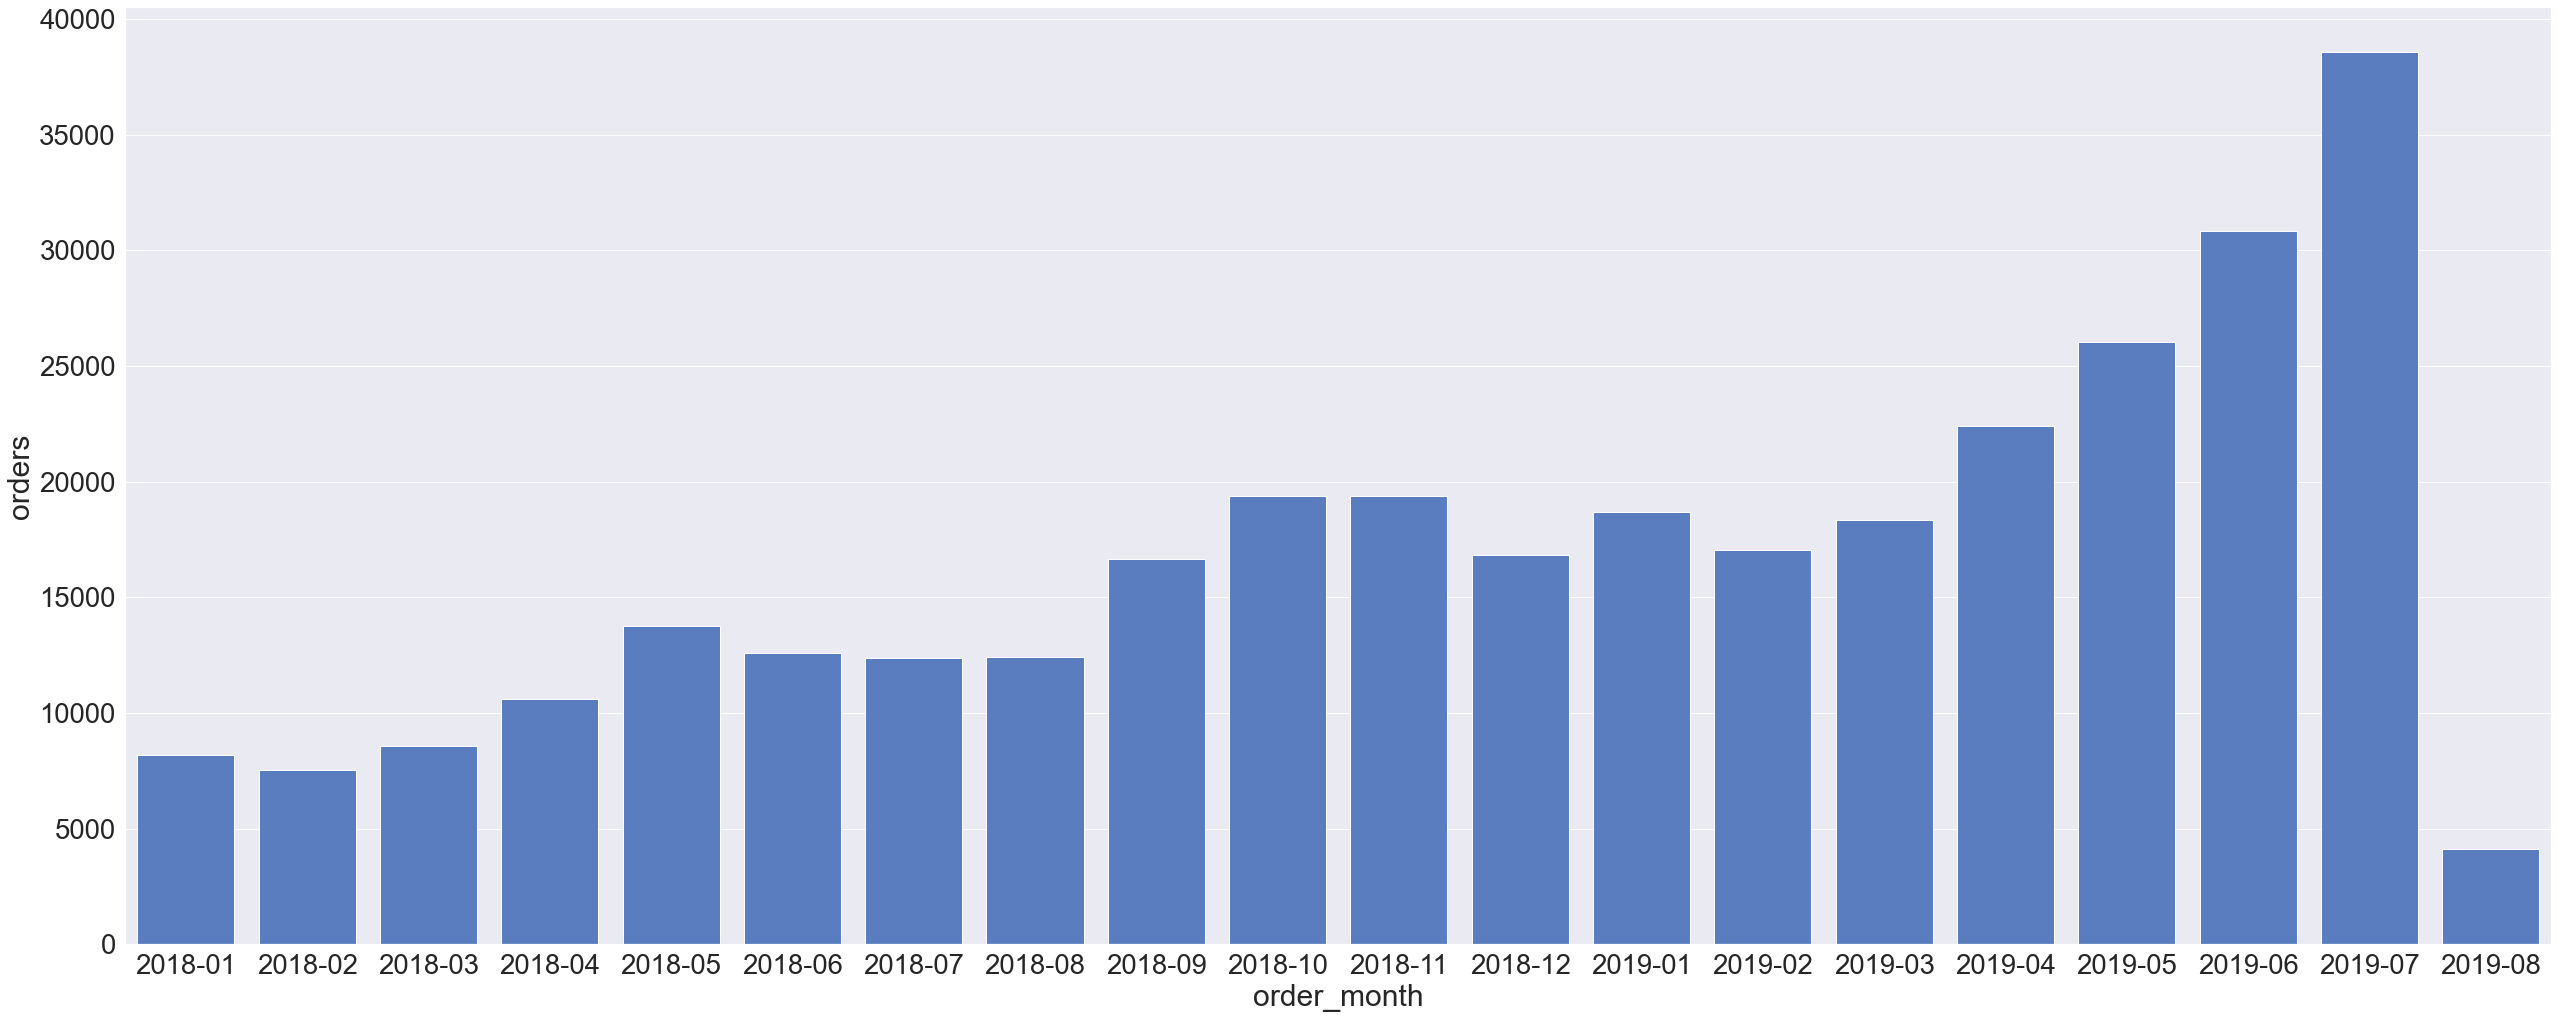

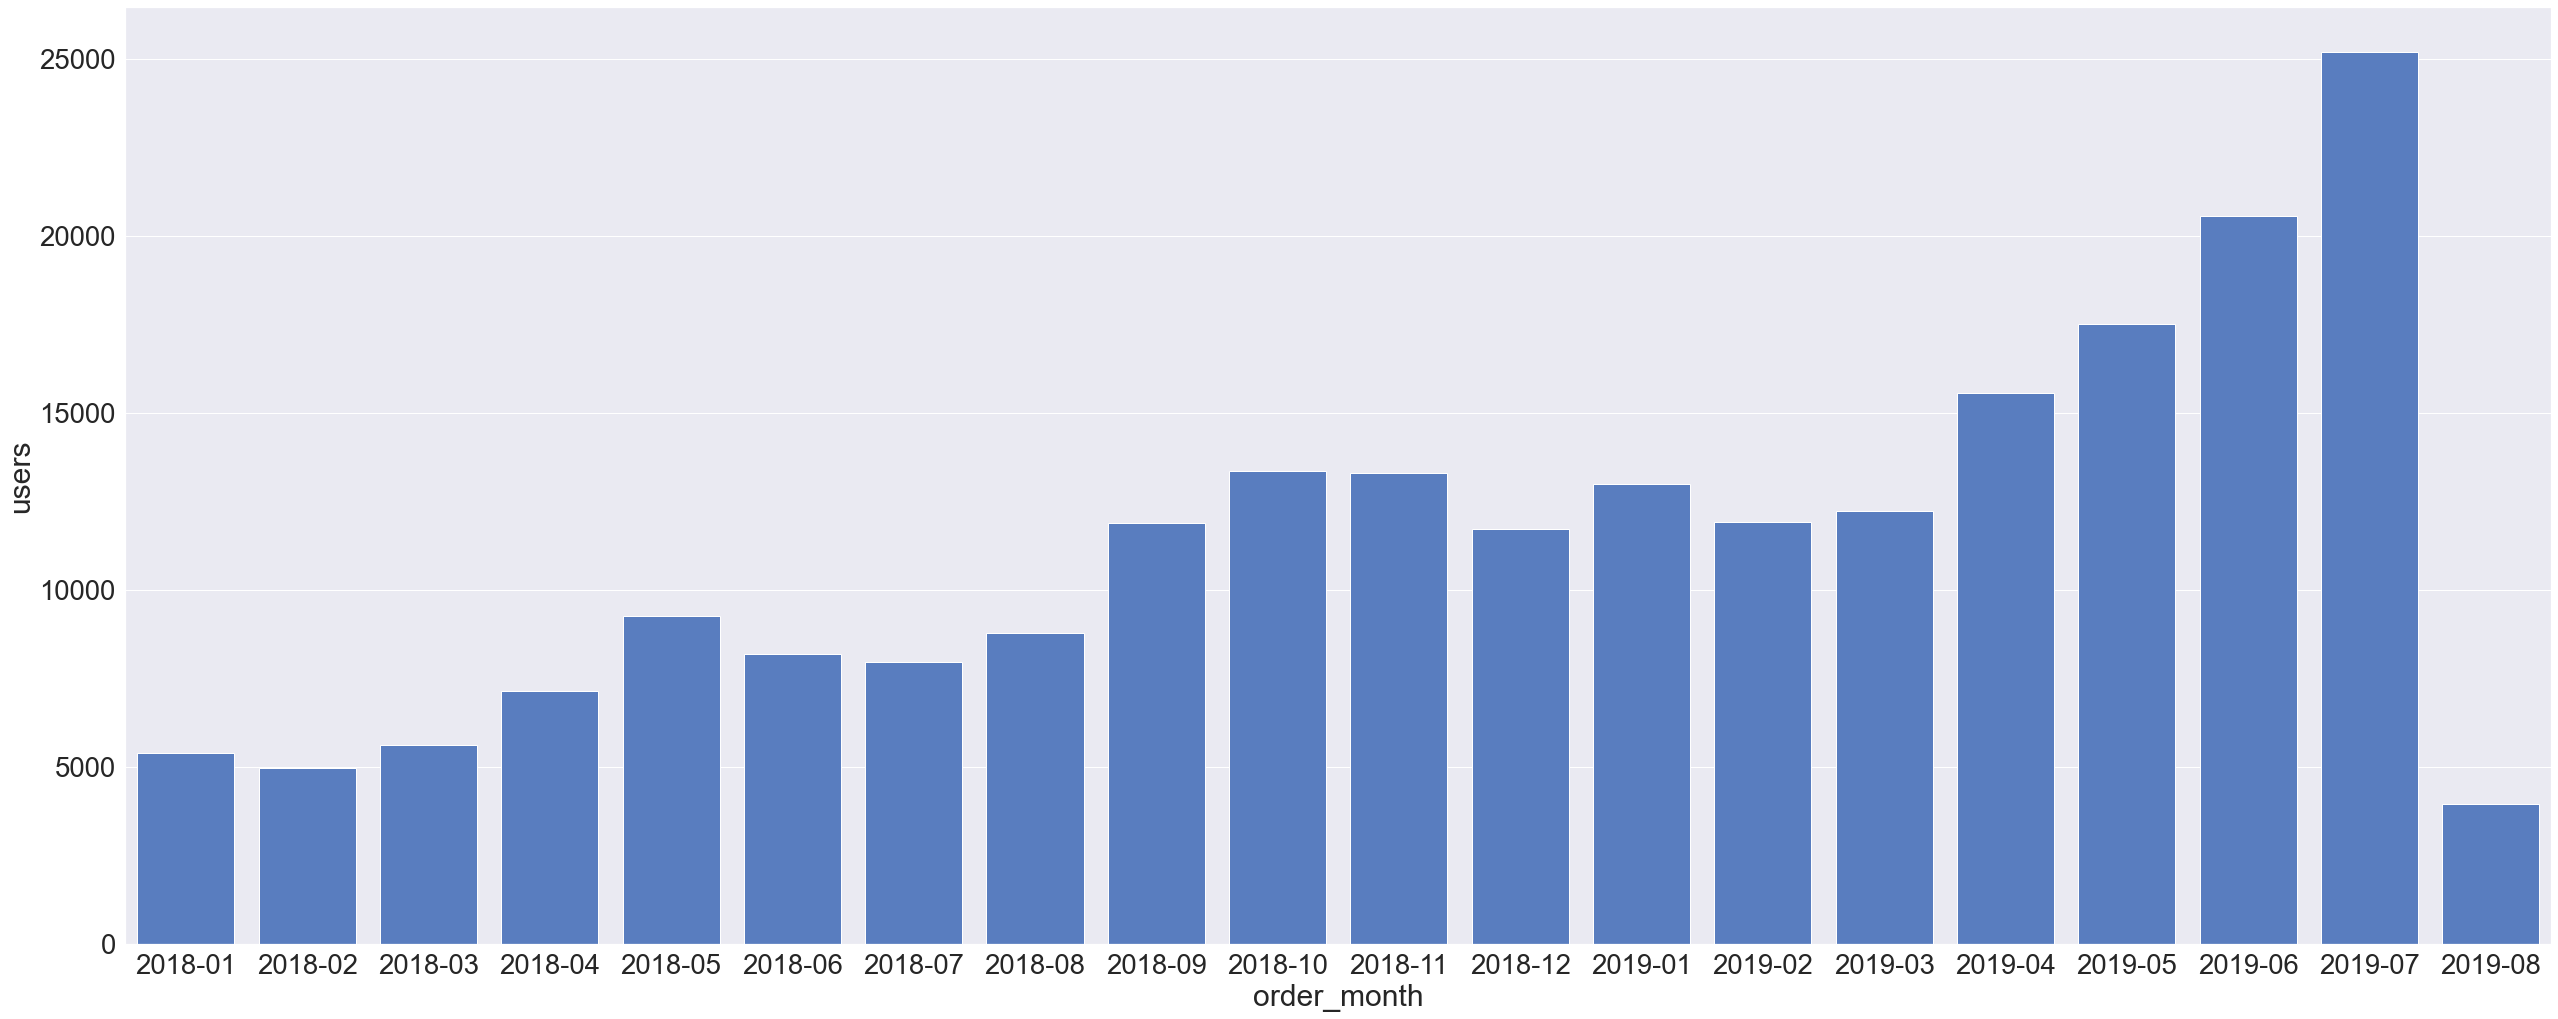

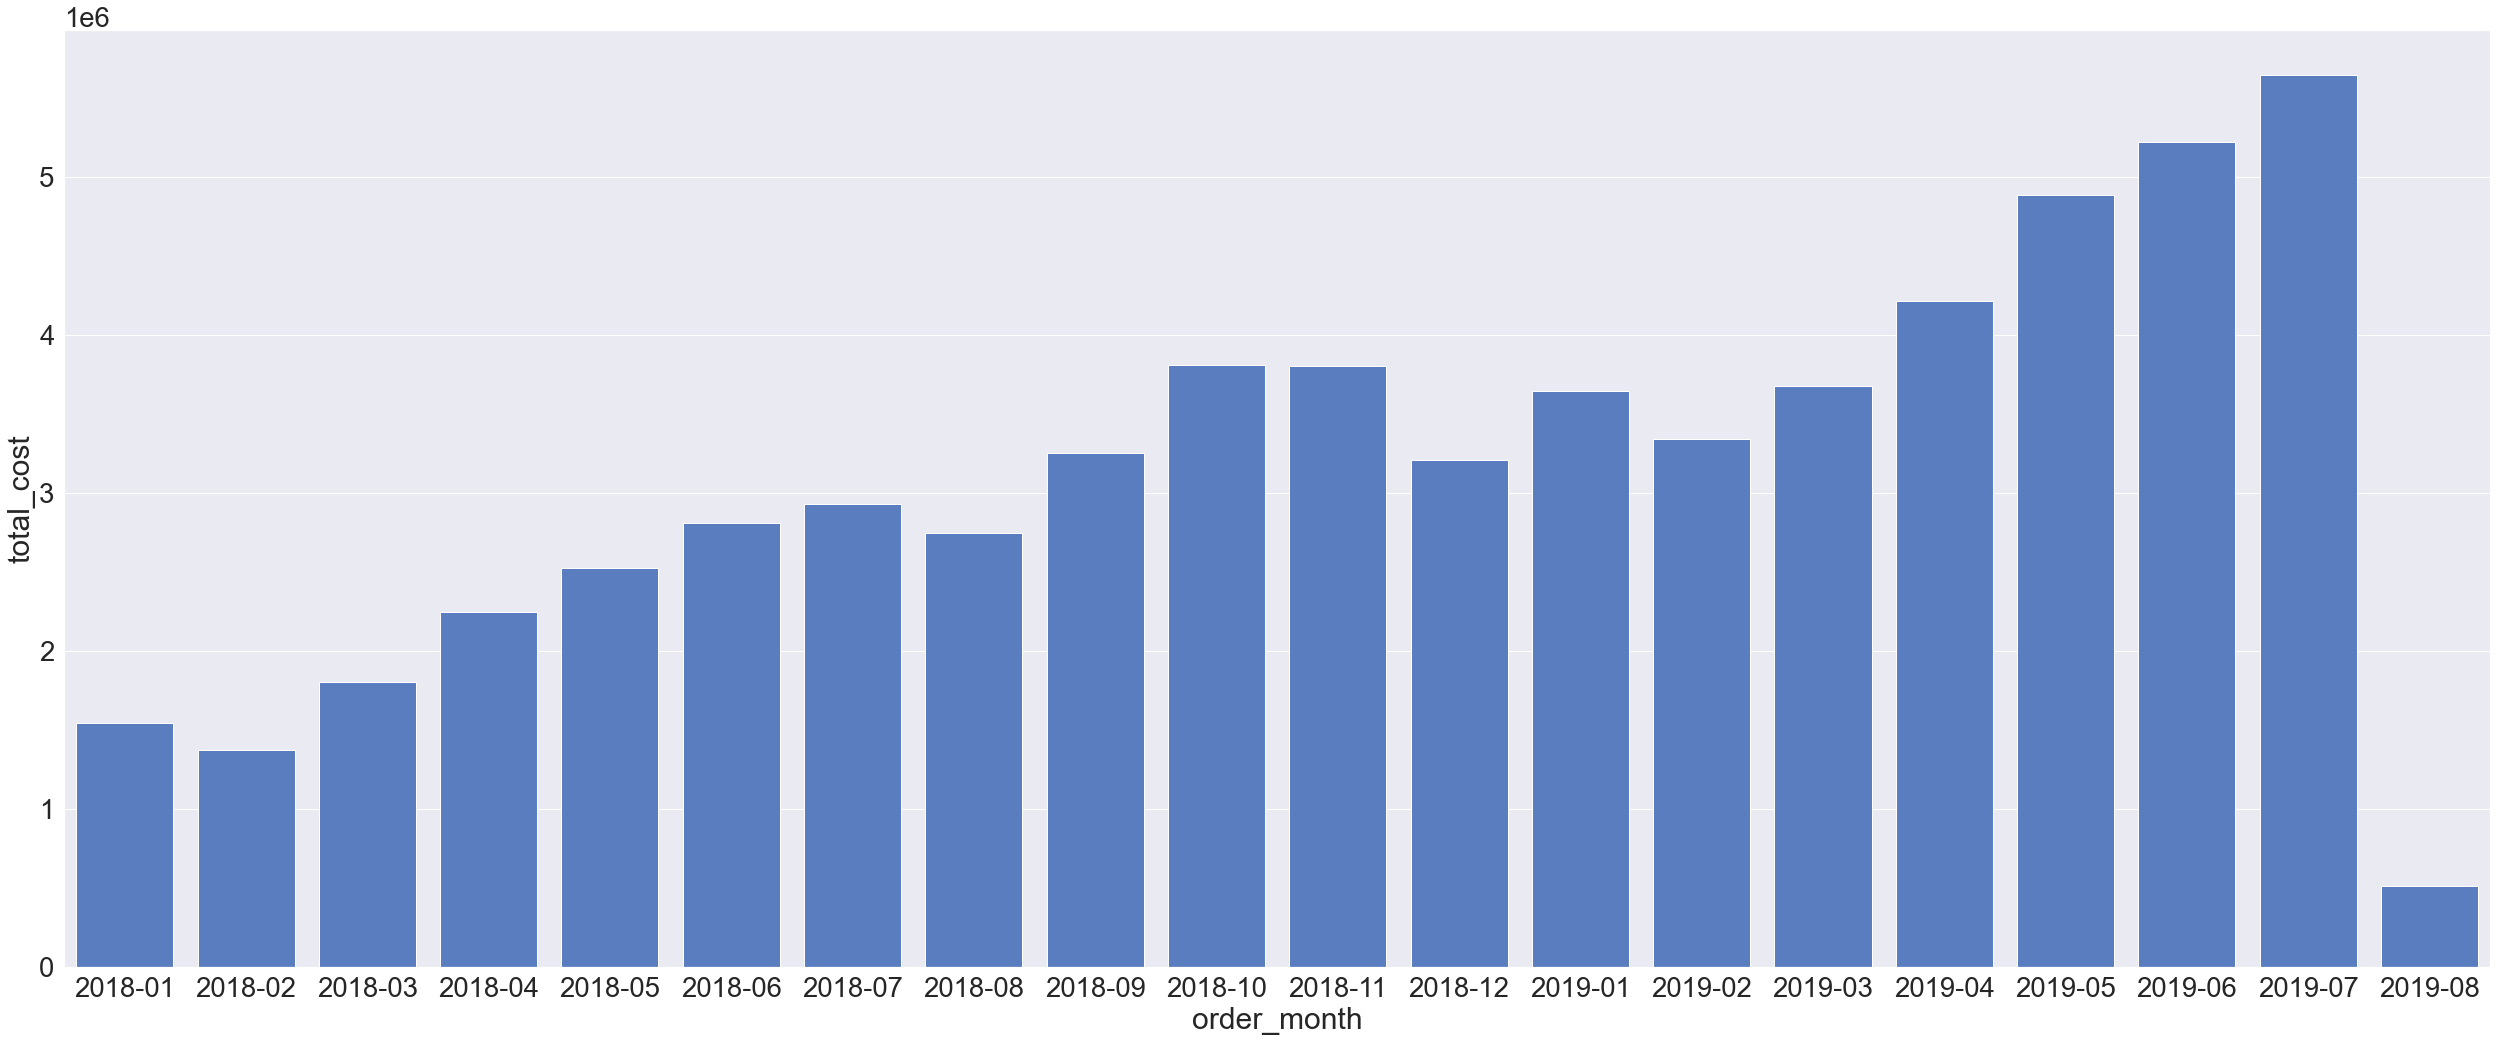

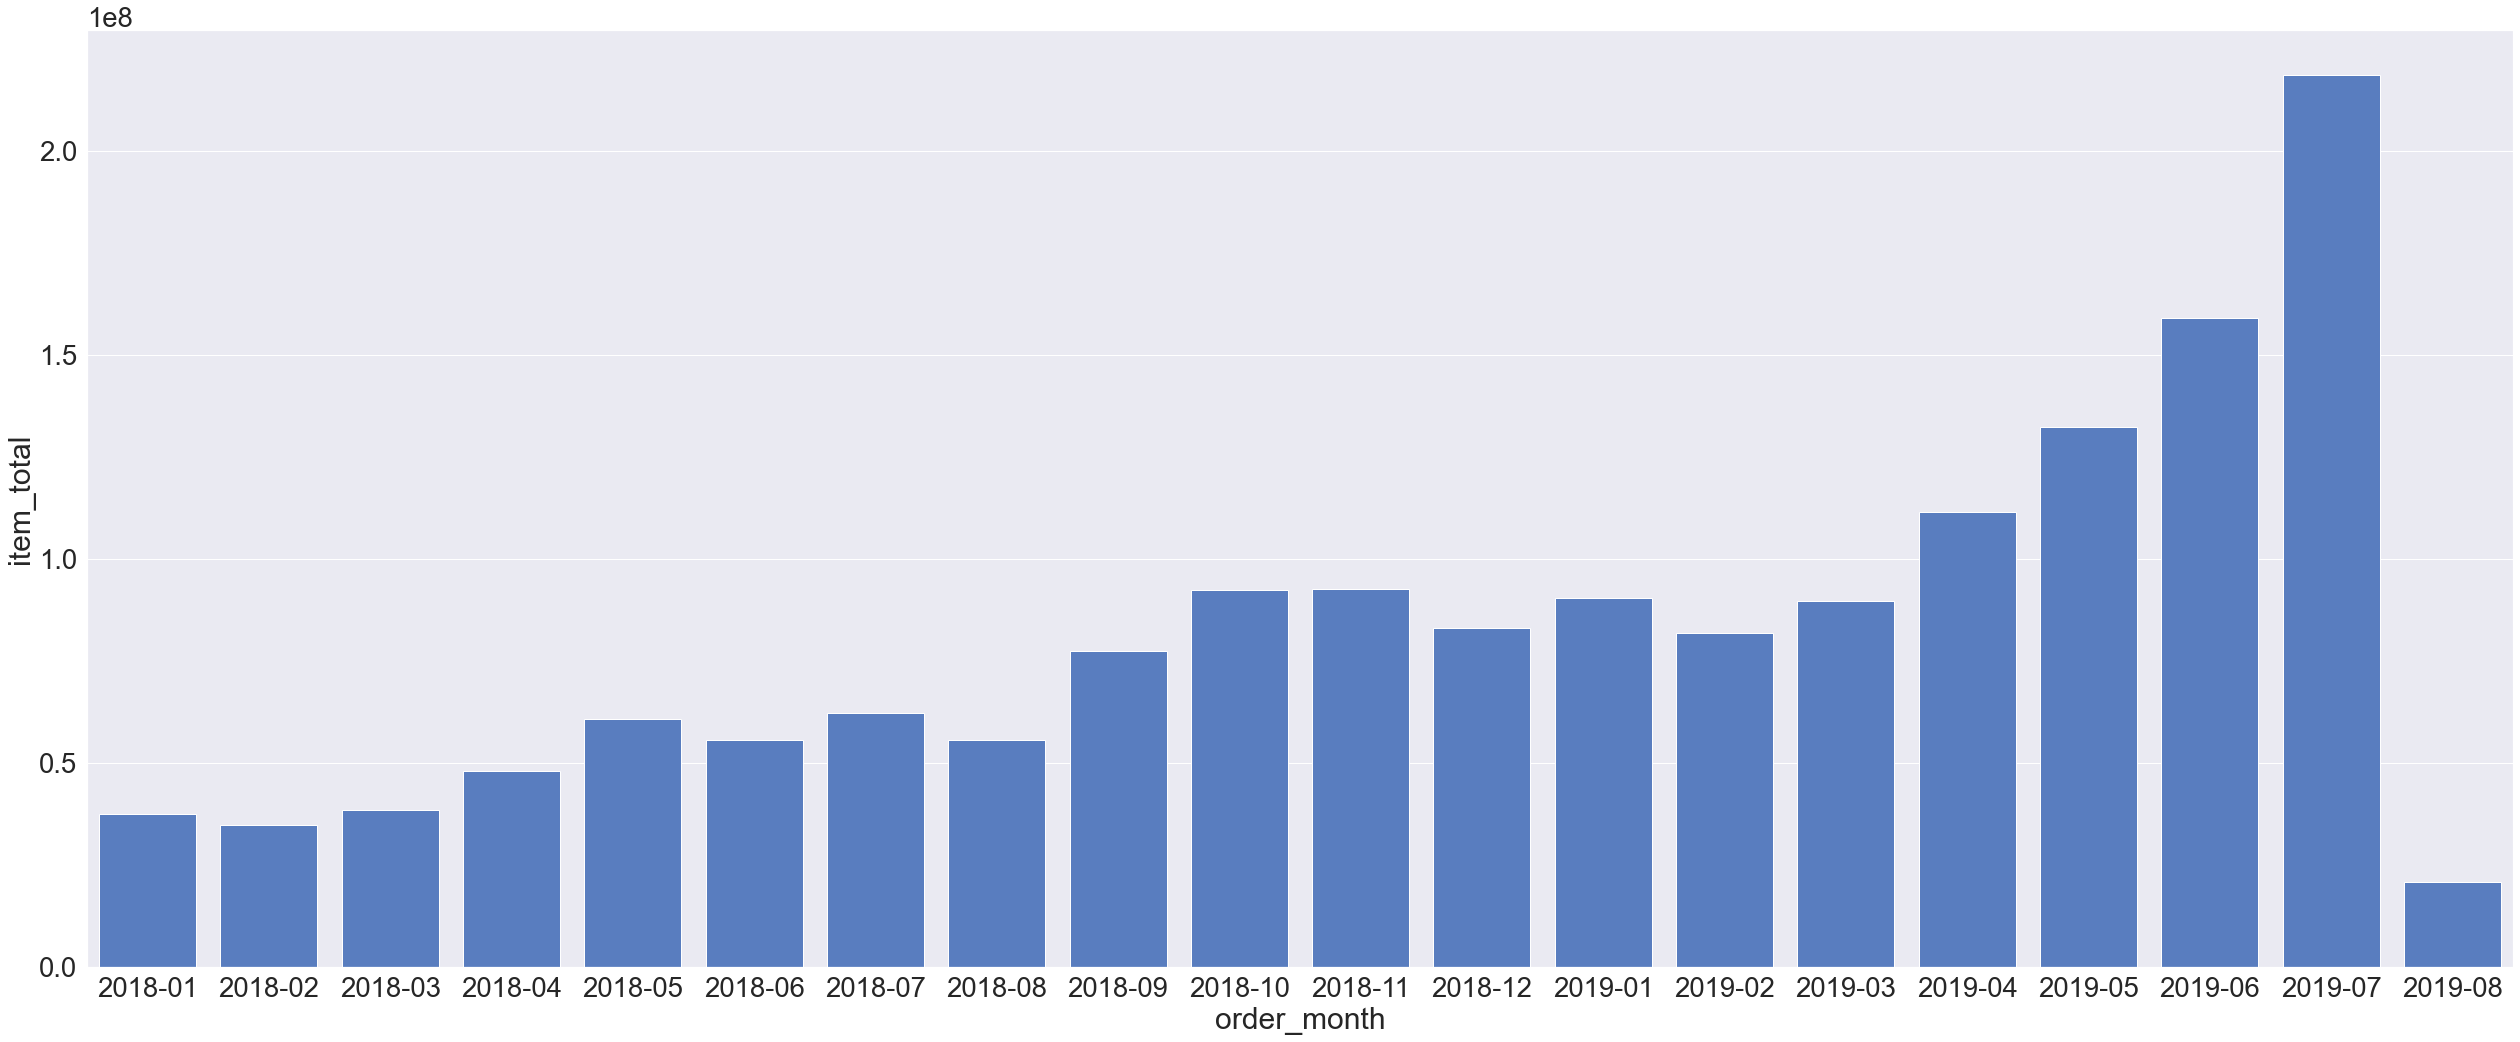

In [21]:
cols = orders_per_month.columns

number_of_columns = 4
number_of_rows = len(cols)-1/number_of_columns
sns.set(font_scale=2.5)

for i in range(1, len(cols)):
    
    plt.subplots(figsize=(200,100))
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_color_codes("muted")
    sns.barplot(x=orders_per_month.order_month, y=orders_per_month[cols[i]], 
                color='b', label=cols[i]) 
    

## Инсайт 5
18, 112 и 120 магазины практически никак не влияют на выручку: мало заказов.
Рост с февраля 2019 скорее всего связан как с увеличением выручки у "старых" популярных магазинов (например, 2, 12, 14, 21), так и с появлением 105 и 108 магазина, которые достаточно быстро завоевали популярность у юзеров 

In [22]:
orders.head()

,id,user_id,total_cost,item_total,promo_total,total_quantity,created_at,store_id,city,retailer_id,order_month
0,3158715,61138,290.0,2543,0.0,35,2018-01-05 00:07:04,2,1,1,2018-01
1,3182881,73307,190.0,6076,0.0,52,2018-01-05 02:04:42,10,1,1,2018-01
2,3146329,75386,290.0,2617,0.0,24,2018-01-05 02:07:35,14,1,1,2018-01
3,3150465,45970,290.0,3422,0.0,23,2018-01-05 02:15:15,21,1,1,2018-01
4,3169087,49089,90.0,3666,0.0,31,2018-01-05 02:48:52,3,1,1,2018-01


In [23]:
months_info = orders.groupby('order_month')

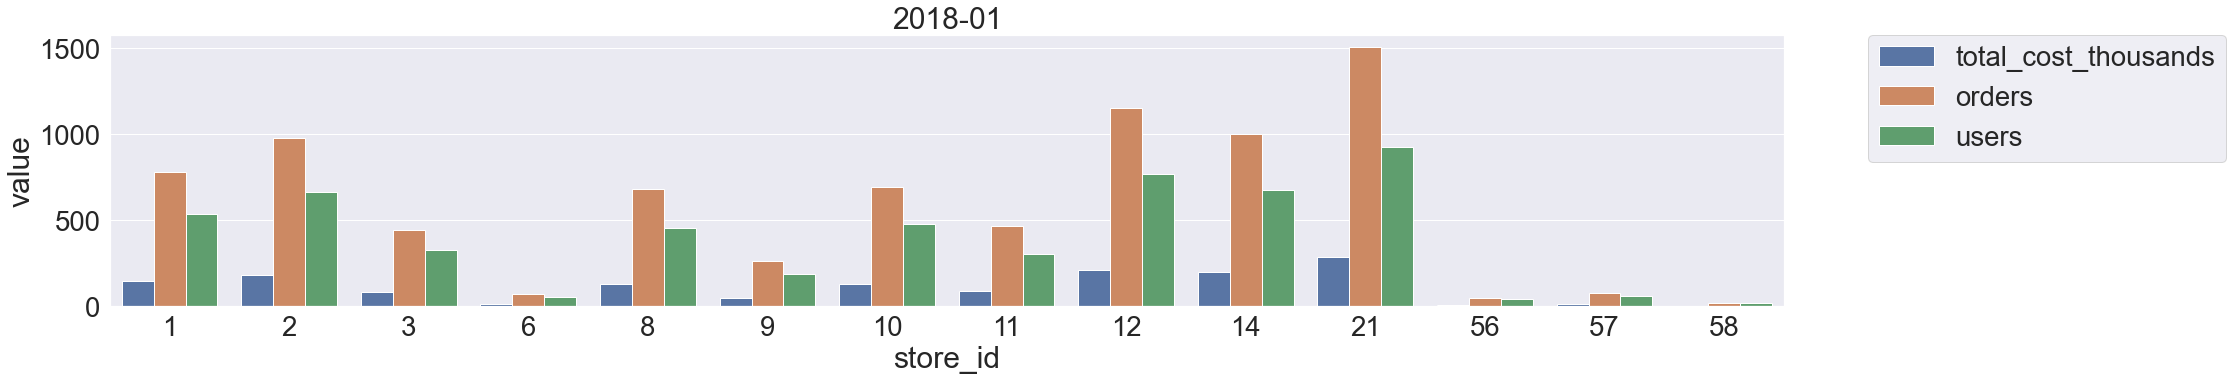

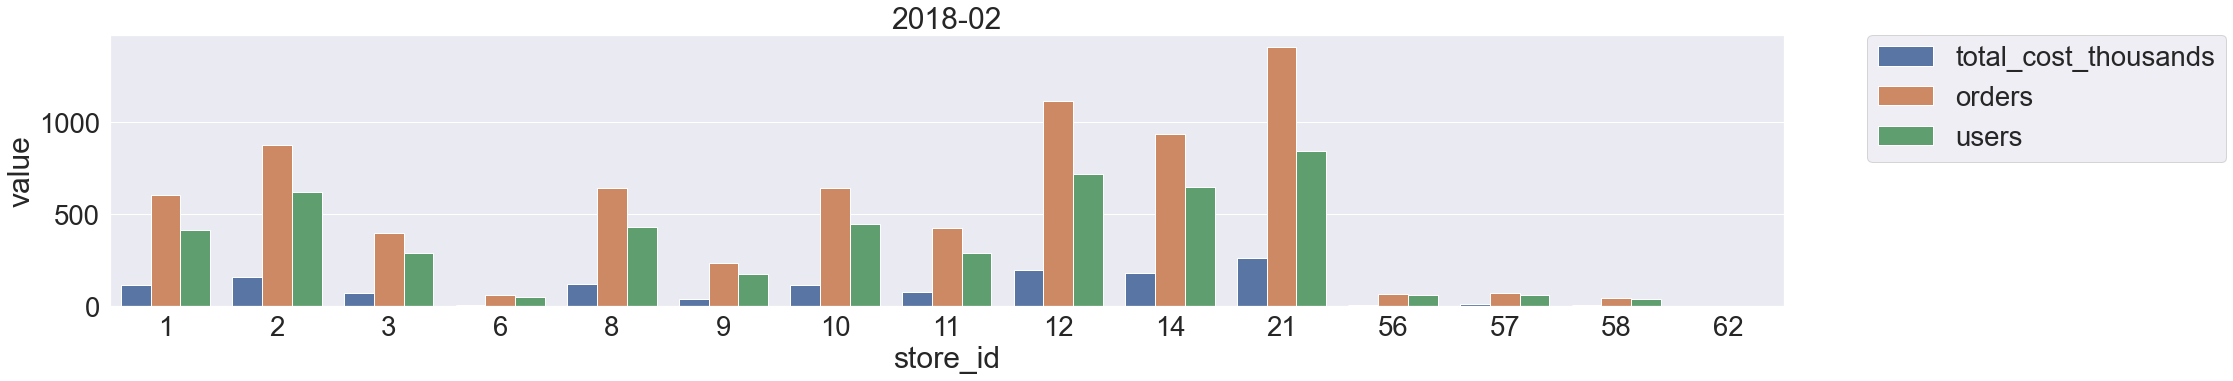

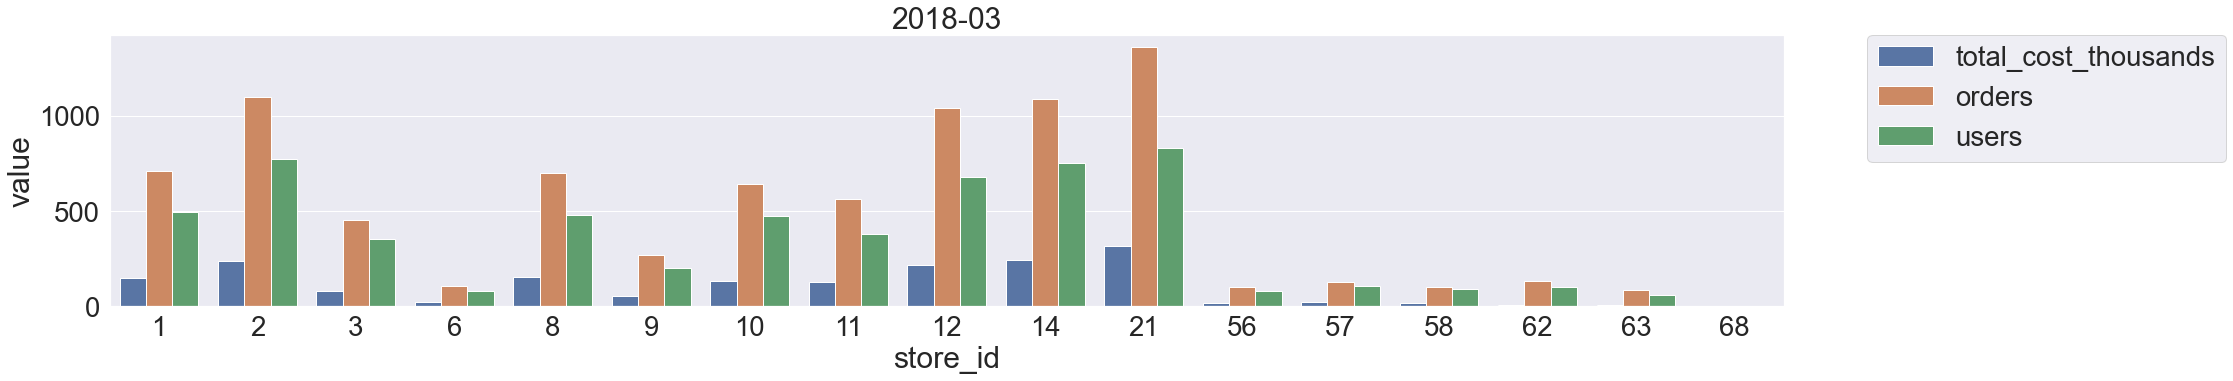

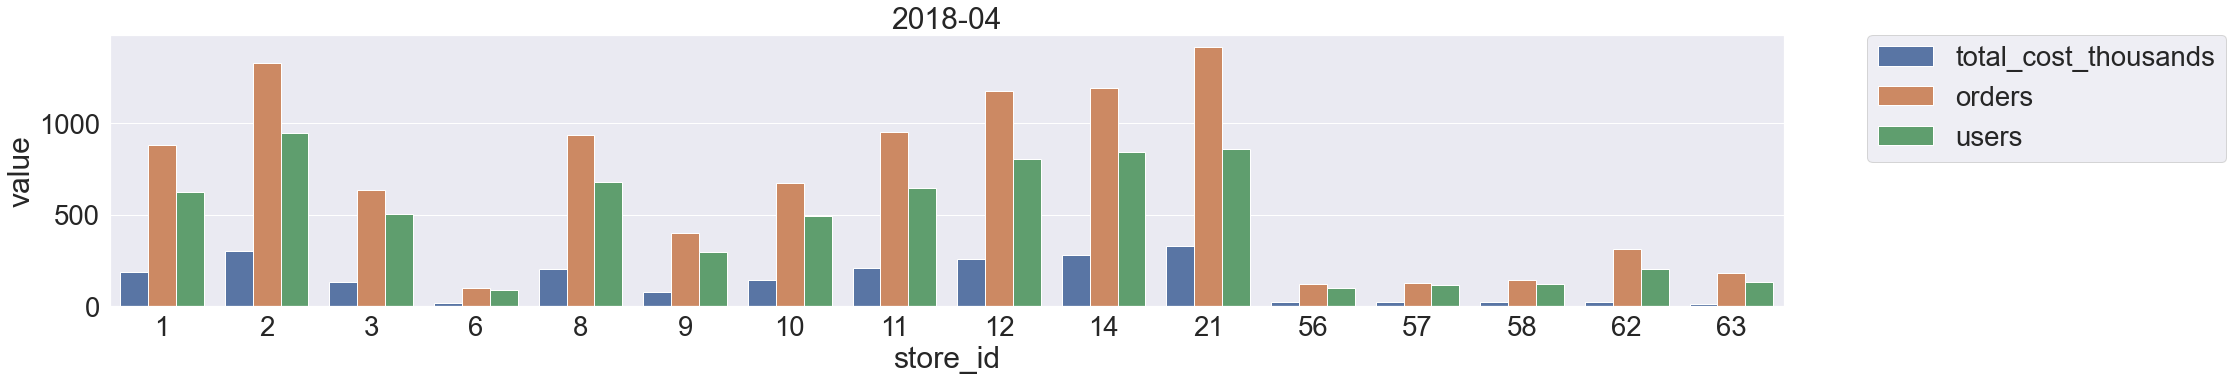

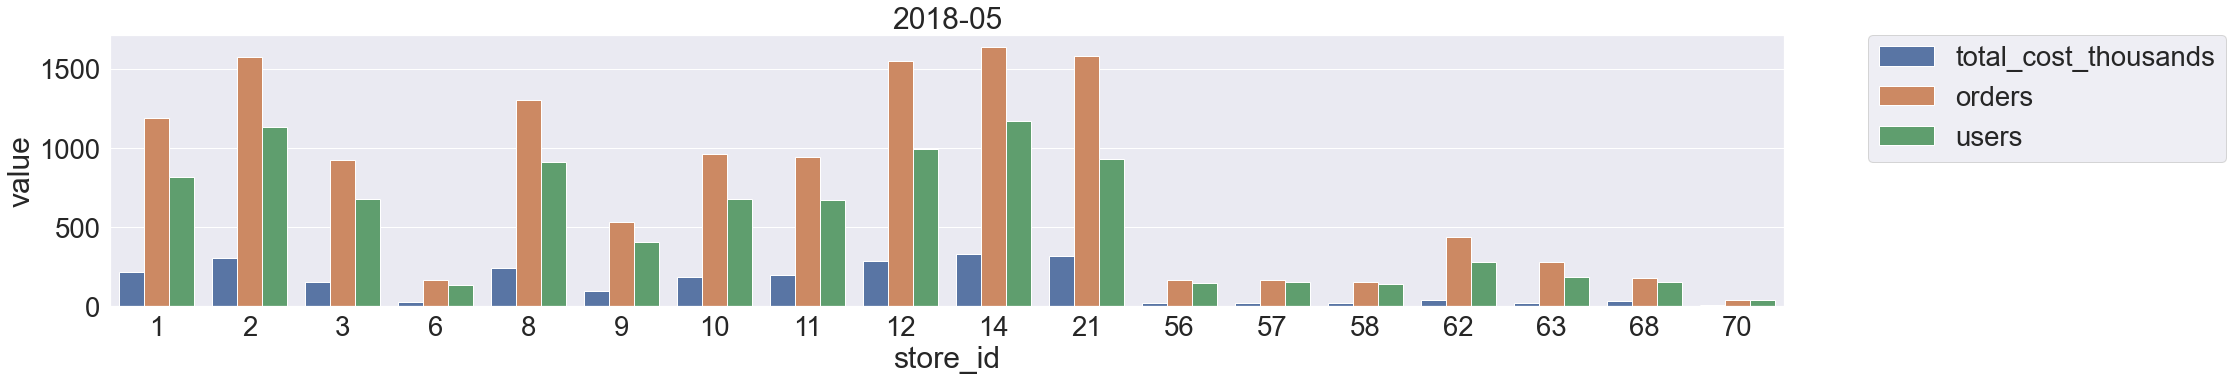

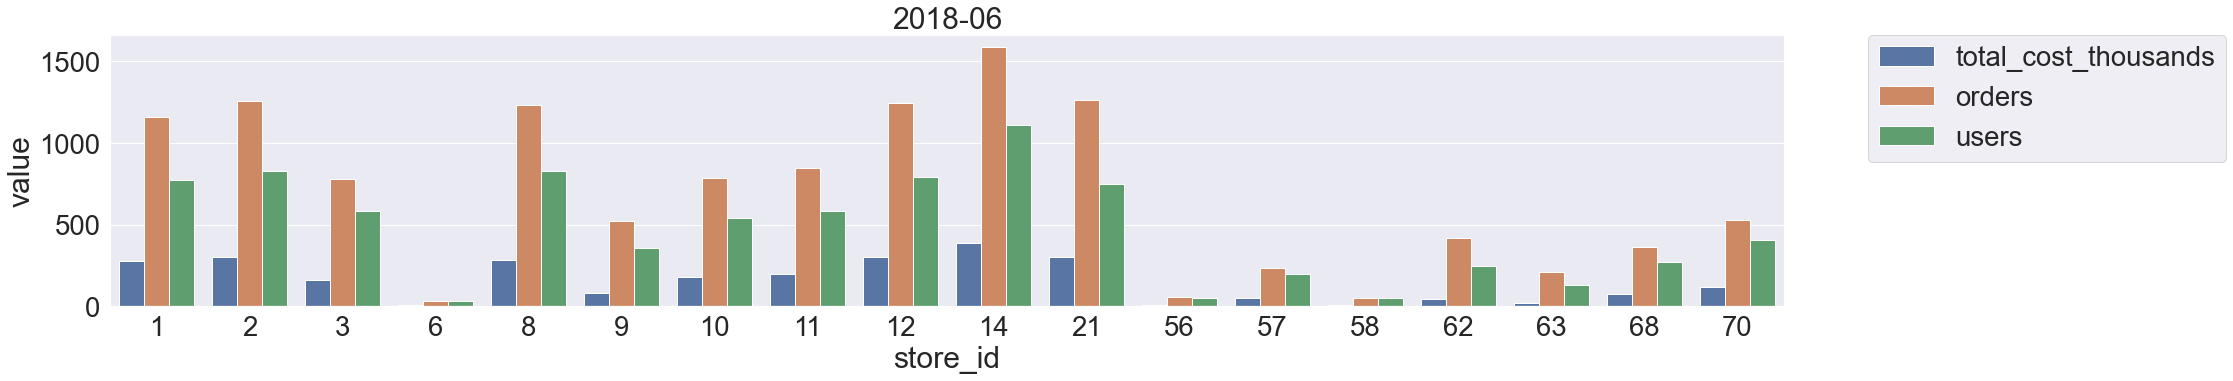

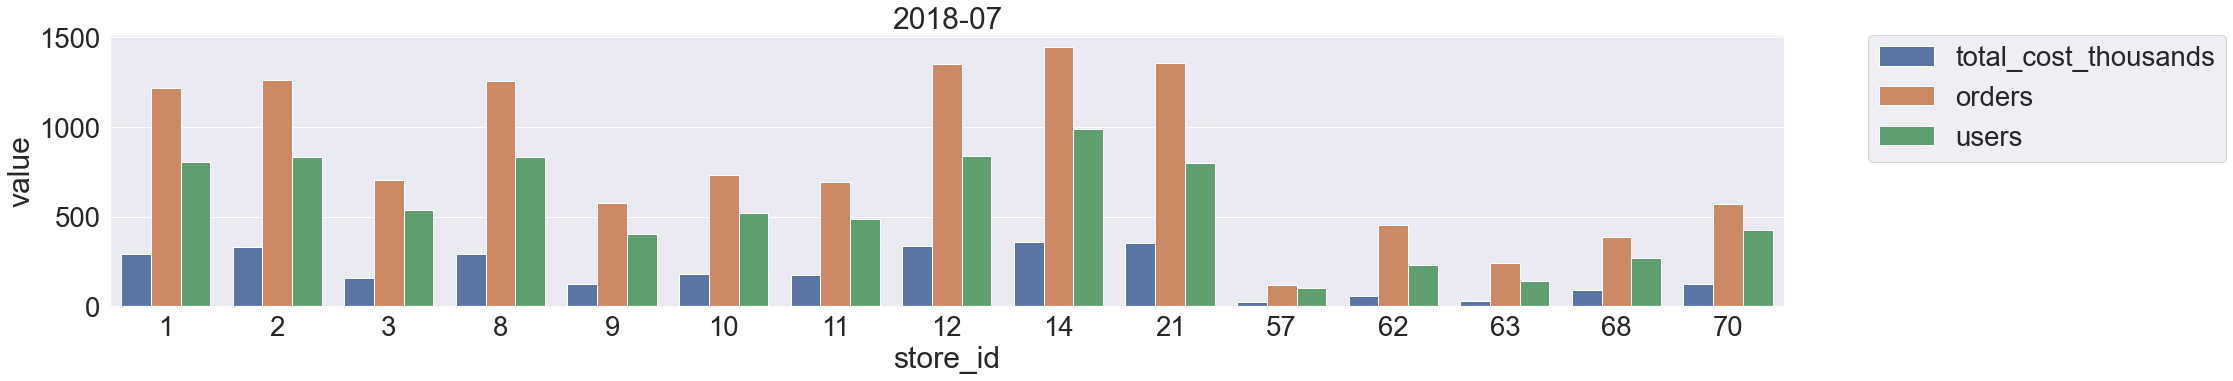

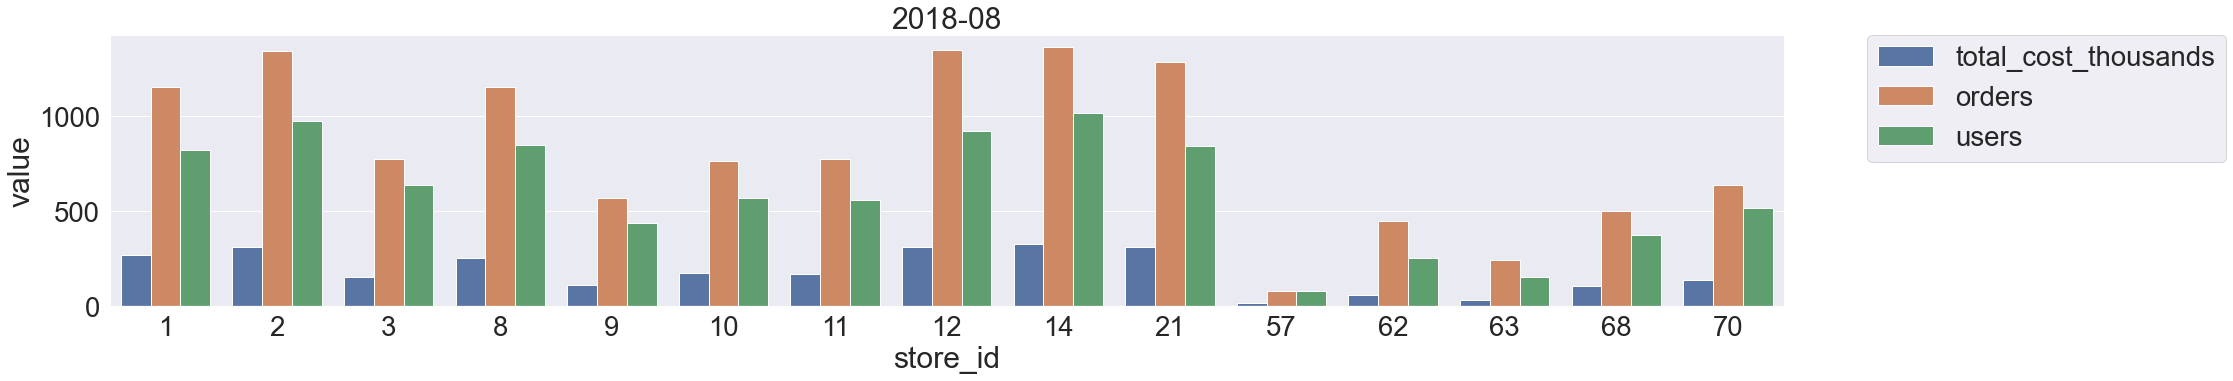

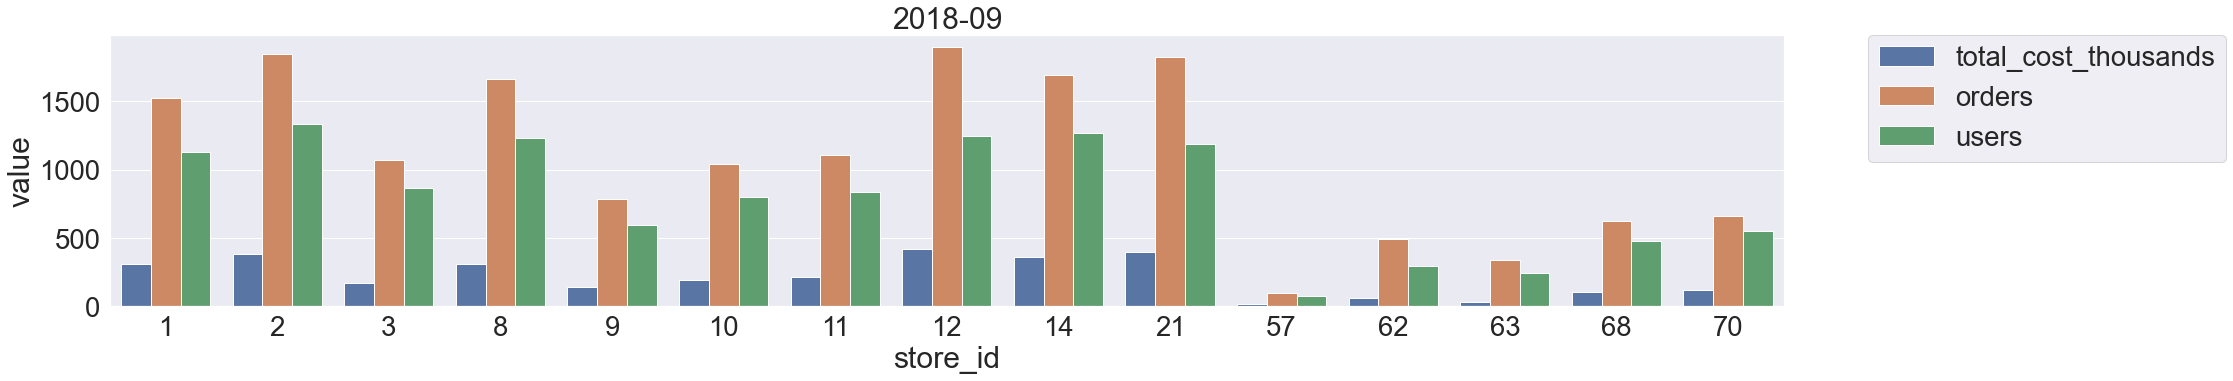

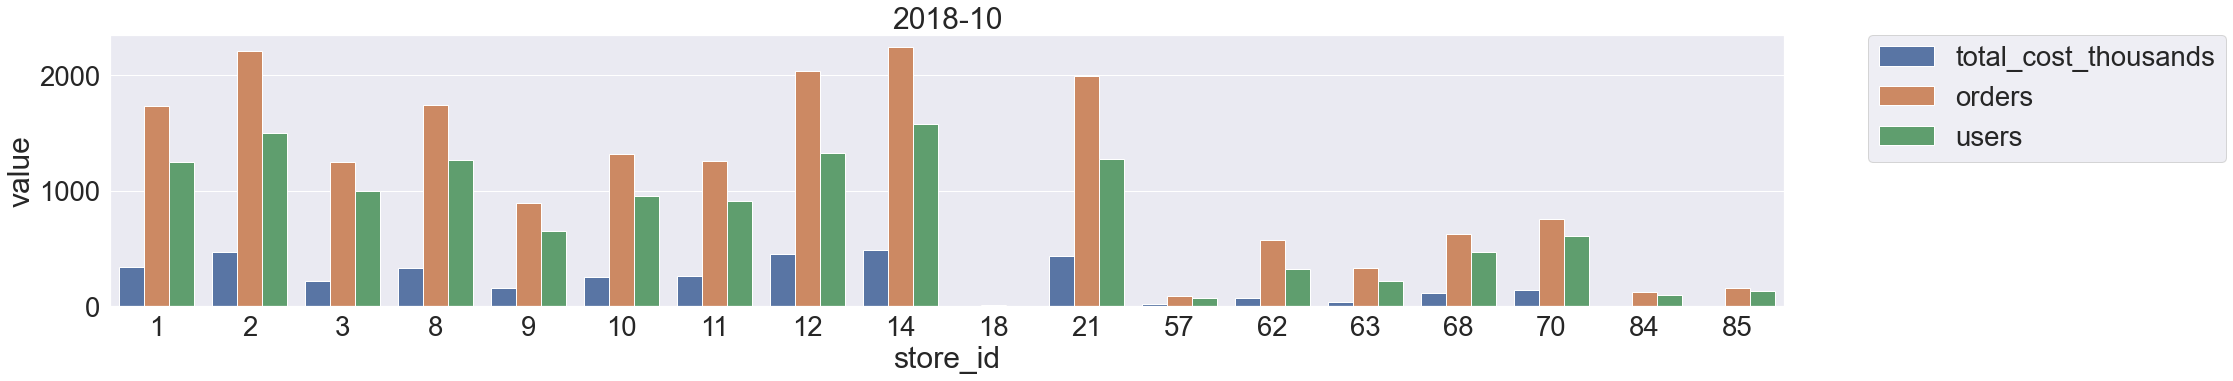

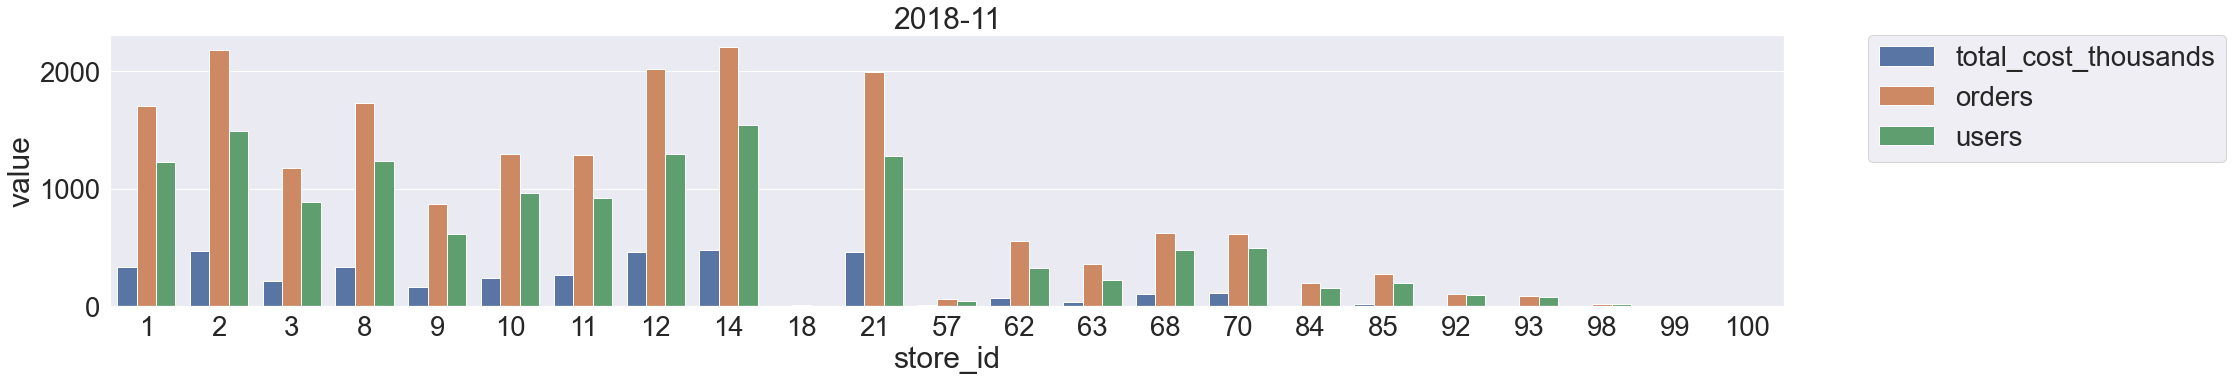

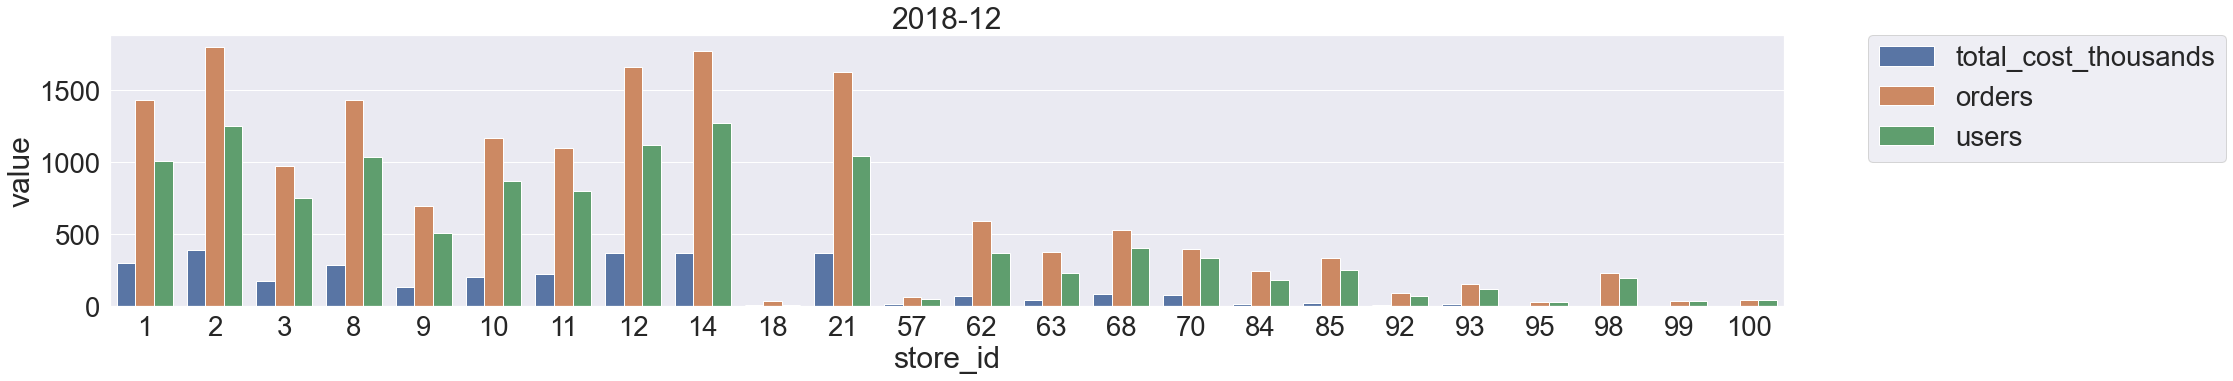

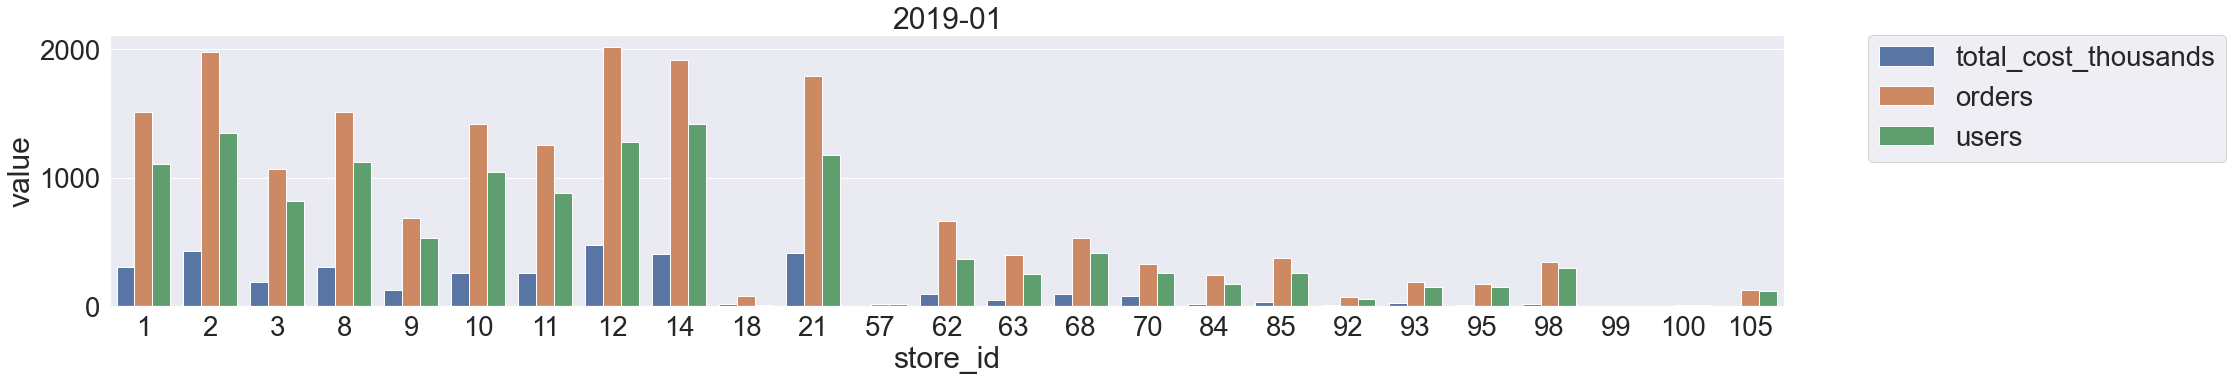

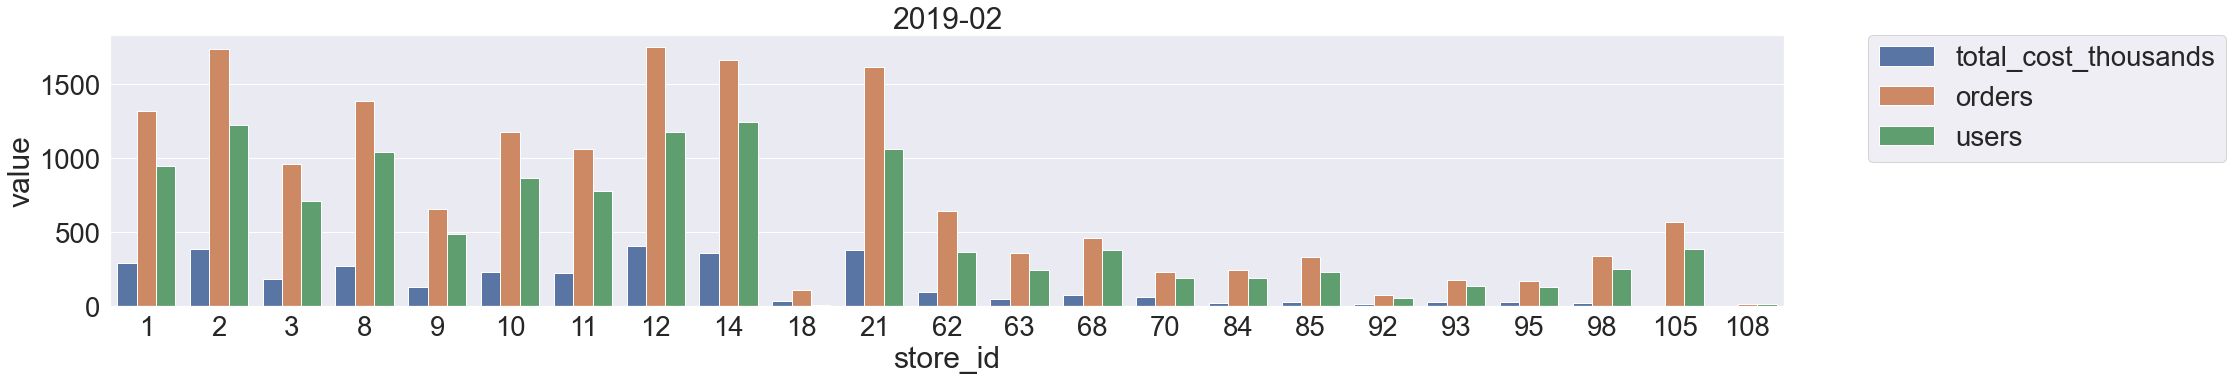

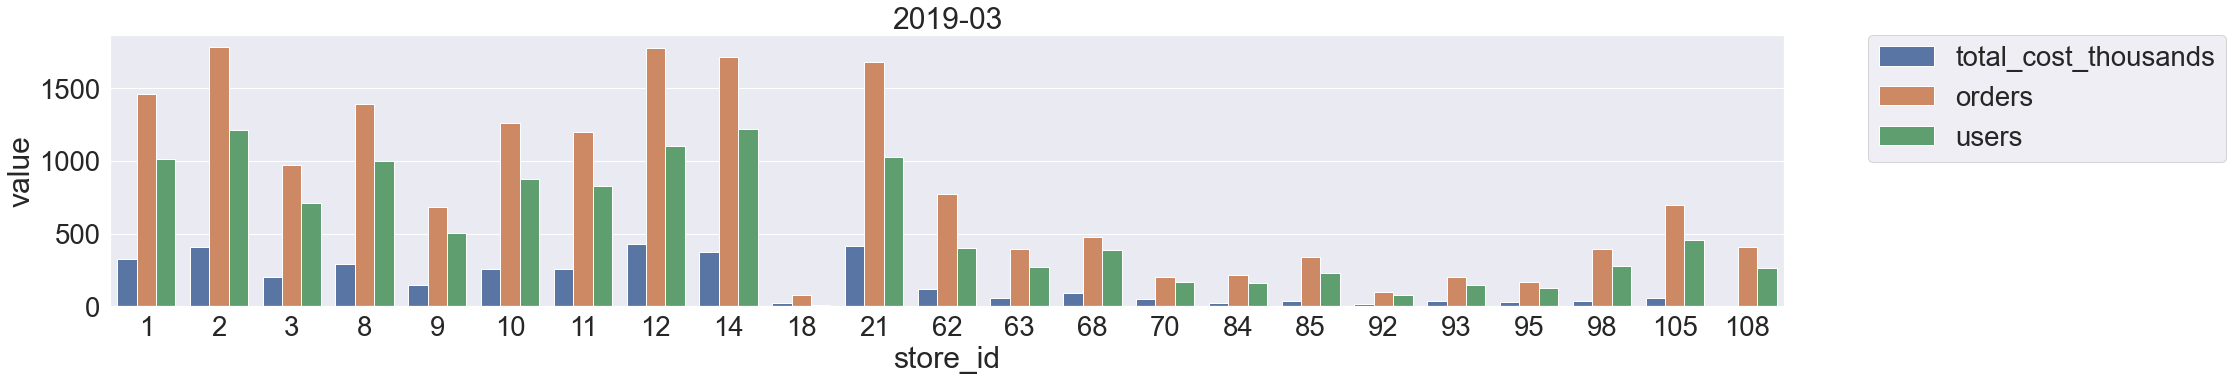

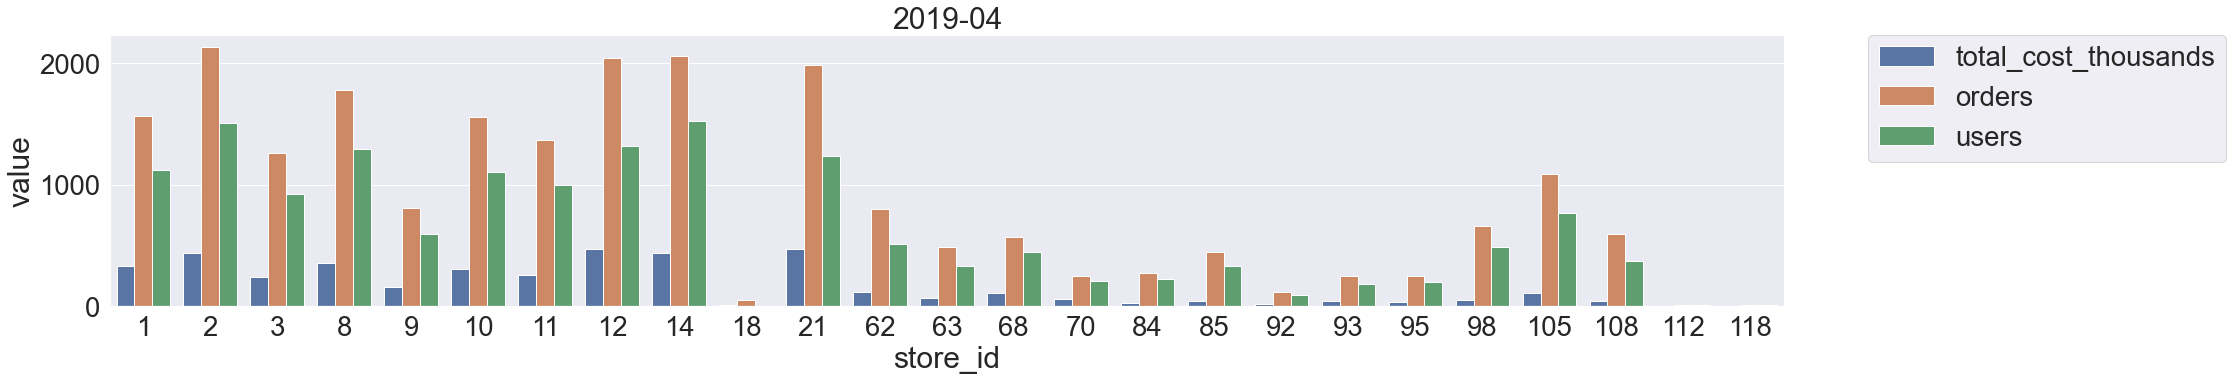

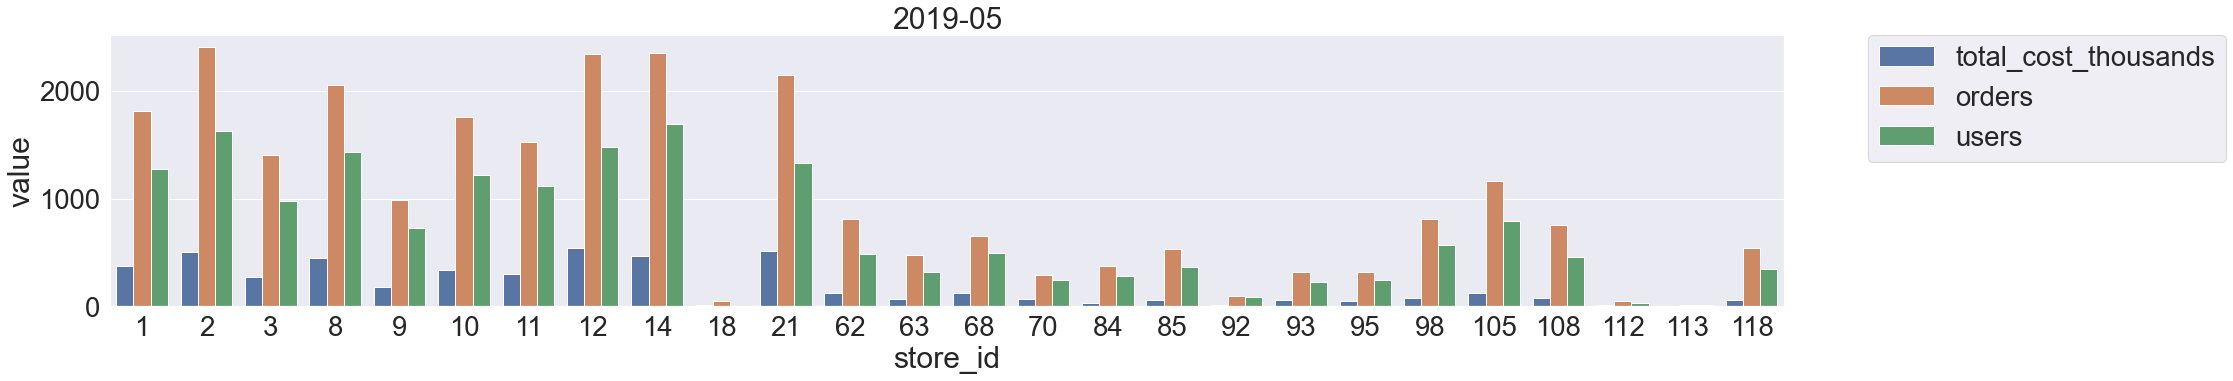

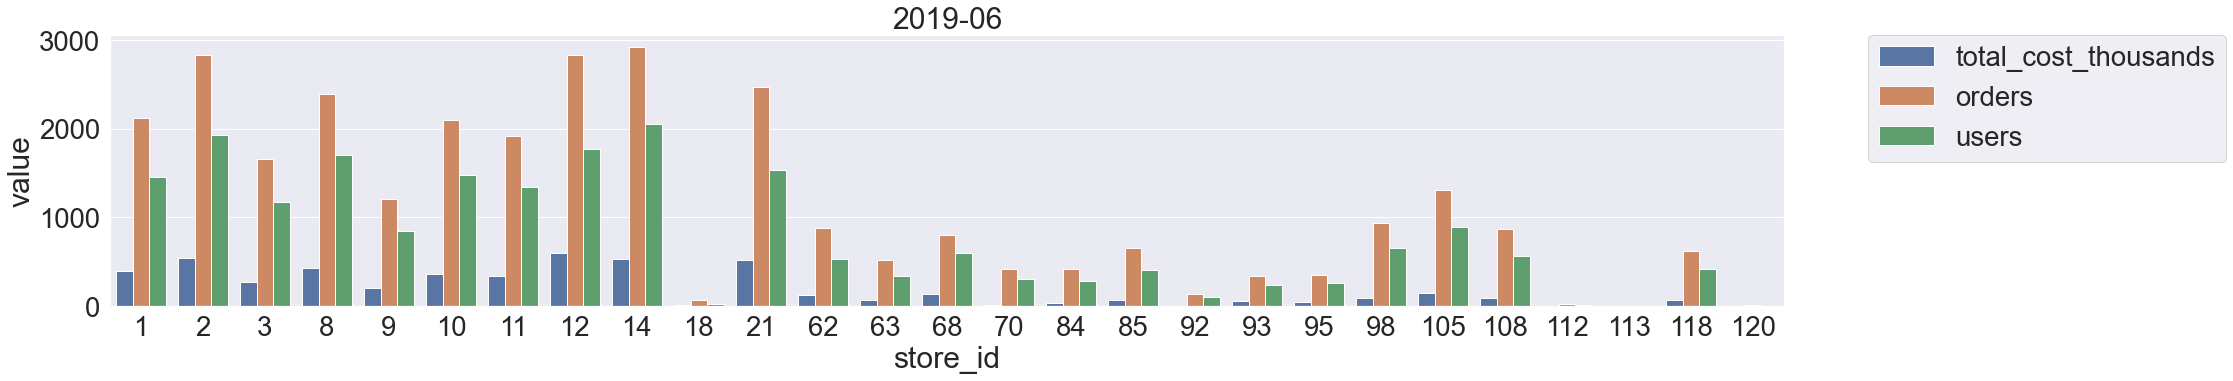

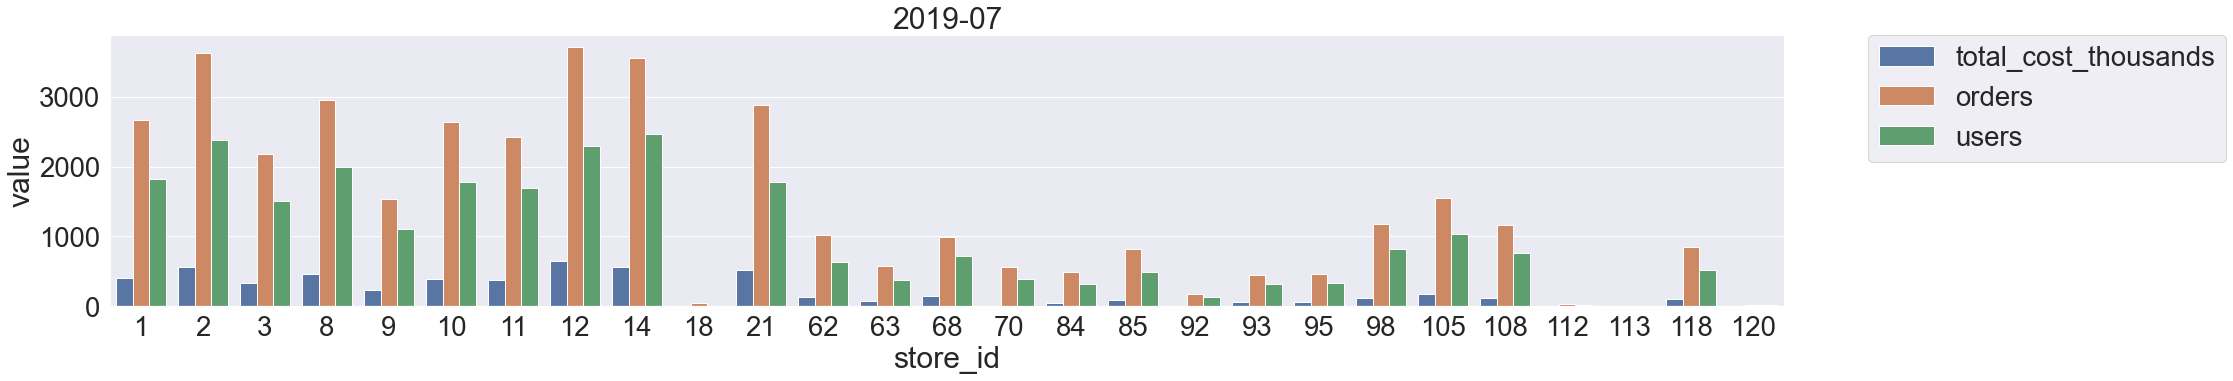

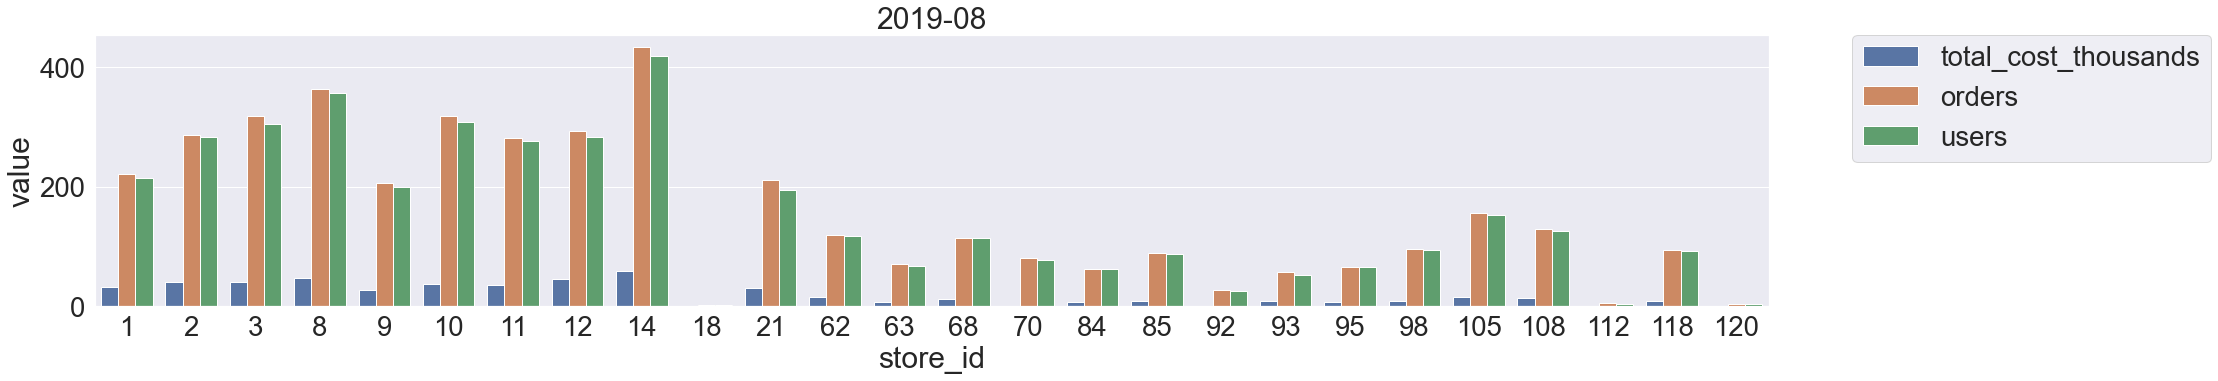

In [24]:
stores_in_months = pd.DataFrame()

for i in orders.order_month.unique():
    # для каждого месяца делаем свой датасет
    month = months_info.get_group(i)
    # группируем каждый месяц по магазинам, получаем сумму выручки с каждого магазина, 
    # количество заказов и количество уникальных пользователей
    month_info = month.groupby('store_id').agg({
            'total_cost': 'sum',
            'id': 'count',
            'user_id': 'nunique'
        }).reset_index().rename(columns={'id': 'orders',
                                         'user_id': 'users'})
    
    # для удобства чтения графика делим сумму выручки на 1000 
    month_info.total_cost = month_info.total_cost.map(lambda x: x/1000)
    month_info = month_info.rename(columns={'total_cost': 'total_cost_thousands'})
    
    # мелтим данные для построения графиков
    melted = month_info.melt(id_vars=['store_id'], 
                             value_vars=['total_cost_thousands', 'orders', 'users'])
    
    # для каждого месяца строим графики
    cols = melted.columns

    number_of_columns = 3
    number_of_rows = len(cols)-1/number_of_columns
    sns.set(font_scale=2.5)

    plt.subplots(figsize=(30,5))

    sns.set_color_codes('muted')
    sns.barplot(x=melted.store_id, y=melted.value, hue=melted.variable).set_title(i)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
        
    

## Инсайт 6

"Постоянные юзеры" составляют 1,5% от общего числа юзеров, они принесли 33% выручки. 
Медианное значение для частоты заказов – 1 раз в 8 дней, медианное значение для количекства заказов – 31. 

"Непостоянные юзеры" составляют 98,5% от общего числа юзеров, они принесли 67% выручки. 
Медианное значение для количества их заказов – 1. 

In [25]:
orders.head()

,id,user_id,total_cost,item_total,promo_total,total_quantity,created_at,store_id,city,retailer_id,order_month
0,3158715,61138,290.0,2543,0.0,35,2018-01-05 00:07:04,2,1,1,2018-01
1,3182881,73307,190.0,6076,0.0,52,2018-01-05 02:04:42,10,1,1,2018-01
2,3146329,75386,290.0,2617,0.0,24,2018-01-05 02:07:35,14,1,1,2018-01
3,3150465,45970,290.0,3422,0.0,23,2018-01-05 02:15:15,21,1,1,2018-01
4,3169087,49089,90.0,3666,0.0,31,2018-01-05 02:48:52,3,1,1,2018-01


In [26]:
user_grouped = orders.groupby('user_id')

In [27]:
# для каждого юзера посчитаем временные промежутки между двумя ближайшими заказами 
# и переведем эти значения в количество дней 
orders['orders_gap'] = orders.groupby('user_id').created_at.apply(lambda x: x - x.shift())
orders.orders_gap = orders.orders_gap.map(lambda x: x.days)

In [28]:
# создадим датафрейм user_behavior, где для каждого юзера будет храниться информация 
# о количестве заказов, потраченной на доставки сумме и медиана всех промежутков между
# двумя ближайшими заказами

users_behavior = orders.groupby('user_id').agg({
                                            'id': 'count',
                                            'total_cost': 'sum',
                                            'orders_gap': 'median',                
                                            }).reset_index() \
                                          .rename(columns={'id': 'orders',
                                                           'orders_gap': 'median_orders_gap'}) \
                                          .fillna(0)

In [29]:
users_behavior.head()

,user_id,orders,total_cost,median_orders_gap
0,31,50,16208.0,10.0
1,45,40,11116.0,12.0
2,60,1,199.0,0.0
3,63,1,249.0,0.0
4,97,8,1748.0,7.0


In [30]:
# уберем из датафрейма колонку с user_id
X = users_behavior.drop('user_id', axis=1)

In [31]:
# определим, какие юзеры относятся к тому или иному кластеру
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2, random_state=42)

In [32]:
model.fit(X)

KMeans(n_clusters=2, random_state=42)

In [33]:
clusters = pd.DataFrame(model.labels_, users_behavior.user_id).reset_index().rename(columns={
    0: 'cluster'
})

In [34]:
users_behavior['cluster'] = clusters.cluster

In [35]:
users_behavior

,user_id,orders,total_cost,median_orders_gap,cluster
0,31,50,16208.0,10.0,1
1,45,40,11116.0,12.0,1
2,60,1,199.0,0.0,0
3,63,1,249.0,0.0,0
4,97,8,1748.0,7.0,0
...,...,...,...,...,...
119026,681550,1,0.0,0.0,0
119027,681627,1,0.0,0.0,0
119028,681806,1,0.0,0.0,0
119029,682248,1,98.0,0.0,0


In [36]:
# соберем информацию по каждому из кластеров

clusters_info = users_behavior.groupby('cluster').agg({
    'user_id': 'nunique',
    'orders': 'sum',
    'total_cost': 'sum',
    'median_orders_gap': 'median'
}).reset_index().rename(columns={'user_id': 'users'})

clusters_info['orders_median'] = users_behavior.groupby('cluster').agg({
    'orders': 'median'
})

In [37]:
clusters_info

,cluster,users,orders,total_cost,median_orders_gap,orders_median
0,0,117212,264850,42438367.42,0.0,1
1,1,1819,69395,20757076.80,8.0,31


In [38]:
# посчитаем, какой процент юзеров принадлежит тому или иному кластеру от общего кол-ва юзеров,
# и какой процент выручки от общей выручки они принесли
users_percent = pd.DataFrame()
for user in clusters_info.users:
    user_percent = (user/clusters_info.users.sum())
    cluster = int(clusters_info.cluster[clusters_info.users == user])
    temp_df = pd.DataFrame({
        'cluster': [cluster],
        'users_percent': [user_percent]
    }) 
    
    users_percent = users_percent.append(temp_df)
    
total_cost_percent = pd.DataFrame()
for total_cost in clusters_info.total_cost:
    cost_percent = (total_cost/clusters_info.total_cost.sum())
    cluster = int(clusters_info.cluster[clusters_info.total_cost == total_cost])
    temp_df = pd.DataFrame({
        'cluster': [cluster],
        'total_cost_percent': [cost_percent]
    }) 
    
    total_cost_percent = total_cost_percent.append(temp_df)

clusters_info = clusters_info.merge(users_percent[['cluster', 'users_percent']])
clusters_info = clusters_info.merge(total_cost_percent[['cluster', 'total_cost_percent']])

In [39]:
clusters_info

,cluster,users,orders,total_cost,median_orders_gap,orders_median,users_percent,total_cost_percent
0,0,117212,264850,42438367.42,0.0,1,0.984718,0.671542
1,1,1819,69395,20757076.80,8.0,31,0.015282,0.328458


In [40]:
# закрываем подключение
con.close()